In [1]:
import gzip
from typing import Dict, List, Union, Callable
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from time import perf_counter

## Read the data

In [2]:
file = "one-hundred-thousand-numbers.txt.gz"
with gzip.open(file, "rt") as f:
    text = [line.strip() for line in f]
    # Get first 10 k numbers
    text = text[1:10_000]
    text = " . ".join(text)
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [3]:
# Tokenize the dataset
tokens = text.split()
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

## Create the vocabulary


In [4]:
# Create the vocabulary
vocab = []
for token in tokens:
    if token not in vocab:
        vocab.append(token)
vocab[:10]

# One could simply apply sets
# vocab = list(set(tokens))
# But this yields unordered tokens

['one', '.', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [5]:
# Numericalization of tokens
tok2idx = {tok: i for i, tok in enumerate(vocab)}
list(tok2idx.values())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
len(list(tok2idx.values()))

30

In [7]:
# Count of tokens
len([tok2idx[tok] for tok in tokens])

63098

## Language model task

Predict the next token based on the previous three tokens. For that we need to apply a window.

In [8]:
seqs = []
for i in range(0, len(tokens) - 4, 3):
    feature_tokens = tokens[i: i + 3]
    target = tokens[i + 3]
    seqs.append(tuple([feature_tokens, target]))
seqs[:10]

[(['one', '.', 'two'], '.'),
 (['.', 'three', '.'], 'four'),
 (['four', '.', 'five'], '.'),
 (['.', 'six', '.'], 'seven'),
 (['seven', '.', 'eight'], '.'),
 (['.', 'nine', '.'], 'ten'),
 (['ten', '.', 'eleven'], '.'),
 (['.', 'twelve', '.'], 'thirteen'),
 (['thirteen', '.', 'fourteen'], '.'),
 (['.', 'fifteen', '.'], 'sixteen')]

In [9]:
len(seqs)

21032

### Apply the tokenizer

In [10]:
# Apply the tokenization
seqs_tokens = []
for seq in seqs:
    feat, trg = seq
    feat_tok = torch.tensor([tok2idx[f] for f in feat])
    trg_tok = torch.tensor(tok2idx[trg])
    seqs_tokens.append(tuple([feat_tok, trg_tok]))
seqs_tokens[:10]

[(tensor([0, 1, 2]), tensor(1)),
 (tensor([1, 3, 1]), tensor(4)),
 (tensor([4, 1, 5]), tensor(1)),
 (tensor([1, 6, 1]), tensor(7)),
 (tensor([7, 1, 8]), tensor(1)),
 (tensor([1, 9, 1]), tensor(10)),
 (tensor([10,  1, 11]), tensor(1)),
 (tensor([ 1, 12,  1]), tensor(13)),
 (tensor([13,  1, 14]), tensor(1)),
 (tensor([ 1, 15,  1]), tensor(16))]

### Create the dataset and dataloader

In [11]:
class NumbersDataset(Dataset):
    def __init__(self, data):
        features, targets = zip(*data)
        # Convert to the appropriate tensors
        self.features = torch.stack(features)
        self.targets = torch.stack(targets)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
# Split the data into train/val
train_seqs, val_seqs = train_test_split(seqs_tokens,
                                        test_size=.2,
                                        shuffle=False,
                                        random_state=123)

# Create the datasets
train_set = NumbersDataset(train_seqs)
val_set = NumbersDataset(val_seqs)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

## First language model

### The architecture
#### Layers
- **Input Layer**: This layer is formed by a `torch.nn.Embedding` class which is basically a lookup table. This table of dimensions (vocab_size, n_hidden) when called receives a tensor of indices of the vocabulary and returns a vectorial representation for each token. The weights on the embedding layer are initialized randomly from a normal distribution with mean 0 and variance 1.
<div style="text-align: center">
    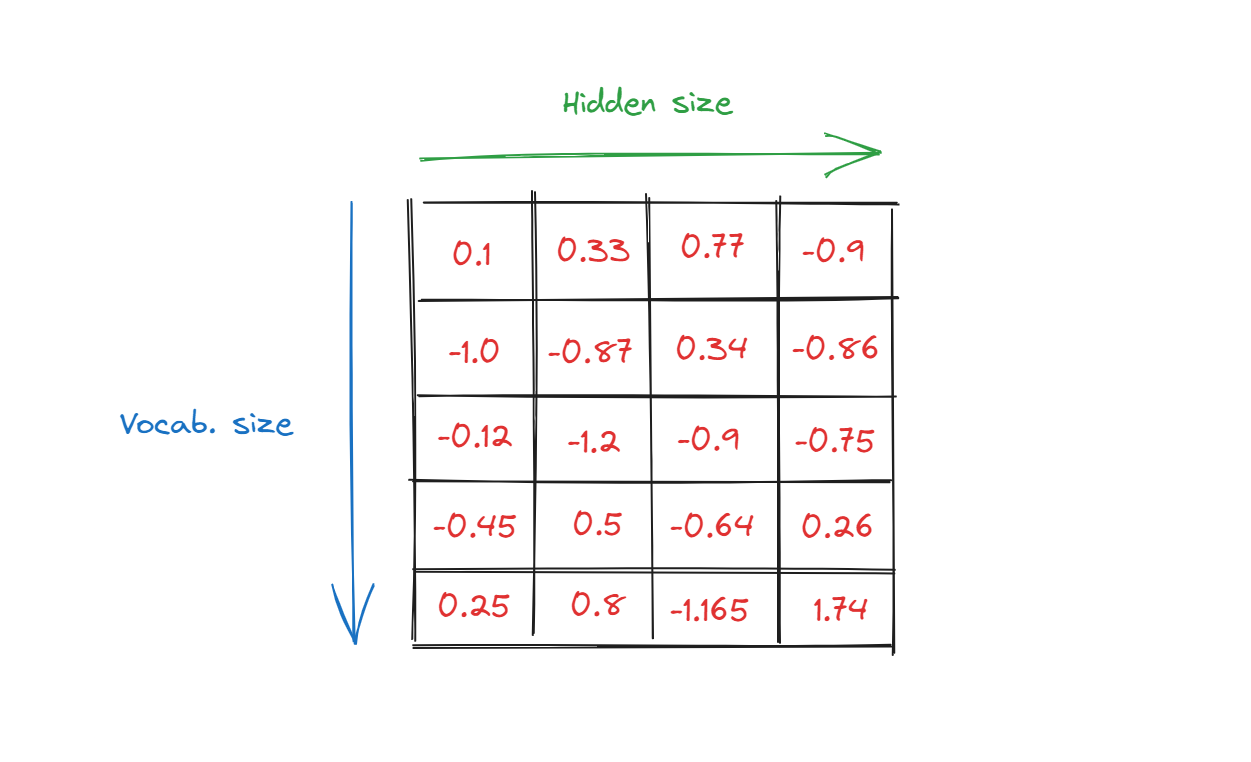
</div>
- **Hidden Layer**: This is just a 2D weigths matrix that receives an input with shape (batch_size, n_hidden) and applies the dot product with the weights matrix of shape (n_hidden, n_hidden). If the case should be of a rectangular matrix, then the parameter of the rows should match the embedding dimension of the input layer and the output tensor would be of shape (batch_size, other_emb_dim).
- **Output Layer**: Finally the output layer should take the inputs of the hidden layer and reshape them into a tensor of shape (batch_size, vocab_size) in order to recover a probability for each possible output that completes the sequence, i.e. the token with the largest probability is the one voted from the whole network to be the next token of the input sequence.

#### Forwarding through the network
- **"*Sequential*" token context**: As we feed the tokens to the network, the activations from the previous tokens is summed with the current token embedding representation then the result is fed to the hidden layer to get the "*interpreted*" information of the sequence which is then applied to the activation function. This makes the network interpret the nth token based on the preceeding ones. Of course, for the first token the information will be just for the first token. See the sketch below:
<div style="text-align: center">
    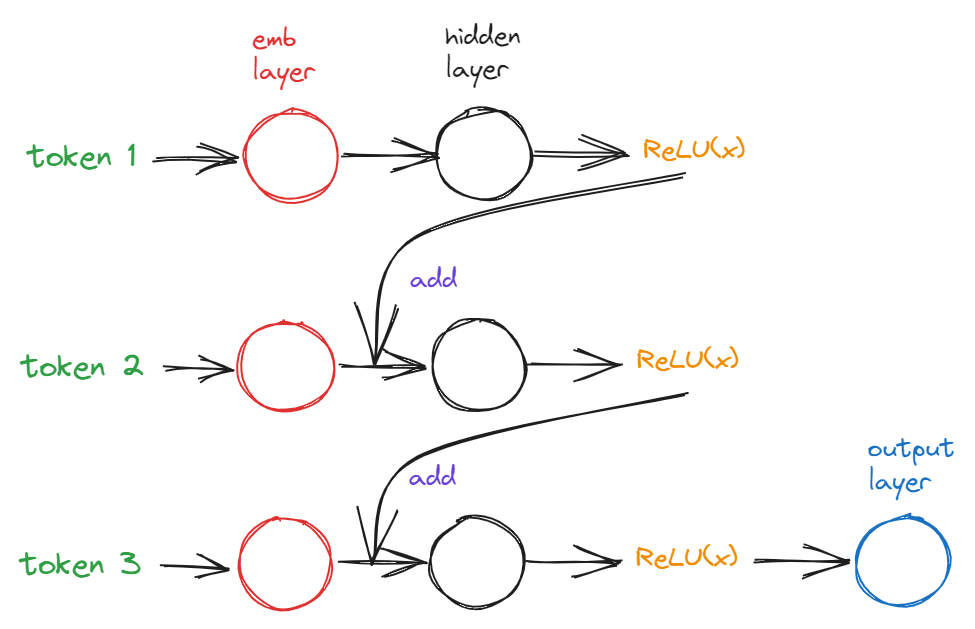
</div>
- **Weight sharing**: There are a couple of theoretical reasons to share weights through the network.
    - **Computational costs**: Adding more weights to the network increases the computational cost when calculating the gradients and also the whole network's size in general if someone wants to train on a longer input sequence of data.
    - **Prone to overfitting**: The fact that there's only one hidden layer with a group of weights forces the network to ignore the *positional* information of the tokens of the sequence. From this perspective, the network is able to generalize better. Think of the NLP task: humans created a ton of complex rules to sentence writting, but these rules are always the same regardless of the word that came before. Basically it's invariant through time and this behavior should be expected. What could *possibly* happen is the network would be trained on a set of data that isn't big enough for it to learn all language nuances and it'd overfit. See below:
<div style="text-align: center">
    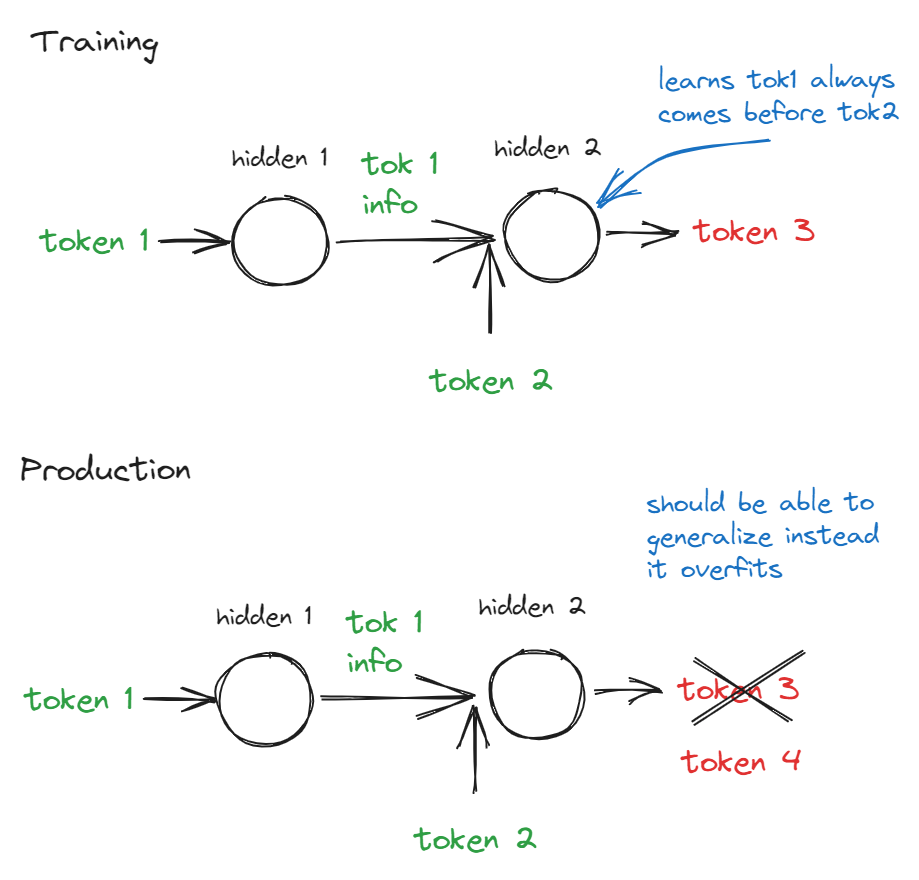
</div>

In [12]:
class SimpleRNN(torch.nn.Module):
    def __init__(self,
                 vocab_size: int,
                 n_hidden: int=3):
        super(SimpleRNN, self).__init__()
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        
        # Layers
        self.input_layer = torch.nn.Embedding(vocab_size, n_hidden) # Lookup table
        self.hidden_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.output_layer = torch.nn.Linear(n_hidden, vocab_size)
        
    def forward(self, 
                X: torch.tensor,
                y: Union[None, torch.tensor]=None) -> Dict:
        # First token
        hidden_state = self.input_layer(X[:, 0])
        hidden_state = self.hidden_layer(hidden_state)
        hidden_state = torch.nn.functional.relu(hidden_state)
        
        # Second token
        # Add the previous token to make the network
        # use the information of previous tokens together
        hidden_state = hidden_state + self.input_layer(X[:, 1])
        hidden_state = self.hidden_layer(hidden_state)
        hidden_state = torch.nn.functional.relu(hidden_state)
        
        # Third token
        hidden_state = hidden_state + self.input_layer(X[:, 2])
        hidden_state = self.hidden_layer(hidden_state)
        hidden_state = torch.nn.functional.relu(hidden_state) # (batch_size, n_hidden)
        
        # Finally get the probabilities
        # for the next token
        hidden_state = self.output_layer(hidden_state) # (batch_size, vocab_size)
        out = {"last_hidden_state": hidden_state}
        
        # Calculate the loss
        if y is not None:
            loss = torch.nn.functional.cross_entropy(hidden_state, y.view(-1,))
            out.update({"loss": loss})
        return out

## Training loop

In [13]:
# Training loop
def train_one_epoch(model, 
                    train_loader,
                    optimizer,
                    device: Union[str, None]=None):
    """
    Trains the network for one epoch.
    """
    # Checks device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
    # Create running loss and sets model to train
    running_loss = 0
    model.to(device)
    model.train()
    for batch in tqdm(train_loader, desc="Train batches", leave=False):
        # Unpack inputs and targets
        inputs, targets = batch
        
        # Send to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero gradients for every batch
        optimizer.zero_grad()
        
        # Compute loss and gradients
        outputs = model(inputs, targets)
        loss = outputs["loss"]
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Report
        running_loss += loss.item()
        
    # Normalize loss per train instance
    avg_loss = running_loss/len(train_loader)
    
    return avg_loss


# Evaluation loop
def evaluate_one_epoch(model,
                       val_loader,
                       device: Union[str, None]=None):
    """
    Runs evaluation for one epoch.
    """
    # Checks device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Running loss and sets model to evaluate
    running_loss = 0
    model.to(device)
    model.eval()
    
    # Store actual labels and predictions
    true_labels = []
    predictions = []
    
    for batch in tqdm(val_loader, desc="Eval batches", leave=False):
        # Unpack inputs and targets
        inputs, targets = batch
        
        # Send to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Compute loss
        with torch.no_grad():
            outputs = model(inputs, targets)
        loss = outputs["loss"]
        
        # Get probabilities and predictions
        hidden_state = outputs["last_hidden_state"]
        # Apply softmax along the last dimension i.e. vocab
        probs = torch.nn.functional.softmax(hidden_state, dim=-1)
        # Select most probable token
        preds = torch.argmax(probs, dim=-1)
        
        # Report
        # Check if targets is 2D, then flatten the list of lists
        if targets.ndim == 2:
            # (batch_size, seq_length) -> (batch_size * seq_length)
            targets = targets.view(-1)
            preds = preds.view(-1)
            
        running_loss += loss.item()
        true_labels.extend(targets.tolist())
        predictions.extend(preds.tolist())
        
    avg_loss = running_loss/len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy


# Train network
def train_network(model,
                  train_loader: DataLoader,
                  val_loader: Union[None, DataLoader]=None,
                  optimizer: torch.optim.Optimizer=torch.optim.SGD, 
                  n_epochs: int=1,
                  learning_rate: float=1e-3,
                  device: Union[None, str]=None):
    """
    Train the network and report metrics.
    """
    # Checks device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Optimizer
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(1, n_epochs + 1), desc="Epochs"):
        # Start timer
        start_time = perf_counter()
        
        # Train model
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate_one_epoch(model, val_loader, device)
        
        # Stop timer and calculate the epoch time in seconds
        end_time = perf_counter()
        epoch_time = end_time - start_time # Seconds
        
        # Report
        print(f"Epoch {epoch} - Train Loss: {train_loss:.3f} - Eval Loss: {val_loss:.3f} - Eval Accuracy: {val_acc:.3f} - Time {epoch_time:.1f}")

In [14]:
# Get vocab size and train the model
torch.manual_seed(123)
vocab_size = len(vocab)
model = SimpleRNN(vocab_size, 64)
train_network(model, train_loader, val_loader, n_epochs=4)

Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Train batches:   0%|          | 0/263 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 3.312 - Eval Loss: 3.256 - Eval Accuracy: 0.148 - Time 0.5


Train batches:   0%|          | 0/263 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 3.166 - Eval Loss: 3.122 - Eval Accuracy: 0.169 - Time 0.5


Train batches:   0%|          | 0/263 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 3.000 - Eval Loss: 2.964 - Eval Accuracy: 0.161 - Time 0.5


Train batches:   0%|          | 0/263 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 2.805 - Eval Loss: 2.781 - Eval Accuracy: 0.173 - Time 0.5


## Maintaining the state of a RNN

Since the performance from the basic RNN is really bad, one idea to try to improve it is to add **more context** when training it to predict the next token. In the begining we had a countinous dataset of written numbers: one, two, three, four, five, ..., ninety nine thousand nine hundred ninety nine (99,999) and we splited it into chunks of 3 tokens to predict the fourth one. So for the first few digits we had: "one, two, three" -> "four", then "two, three, four" -> "five". But what if we could pass the first sequence to the network, which would return a *hidden state* with the information of those numbers, and keep this representation and add it to the next first token of the sequence?
<div style="text-align: center">
    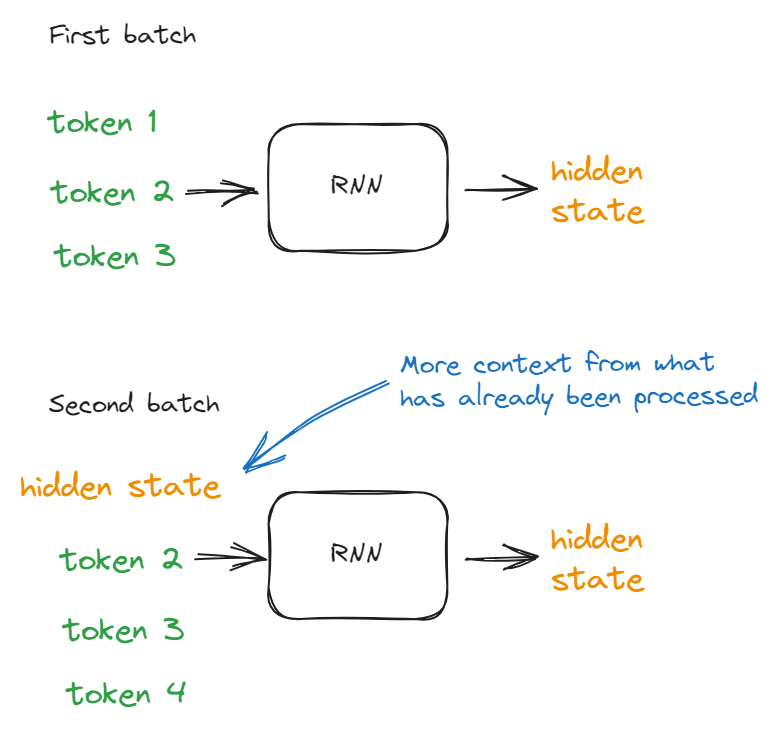
</div>
To do this we simply "*save*" the previous hidden state in a property of the network inside the `__init__()` method. This property starts at zero and as the text flows through the network in the forward pass more context is added to it.

One point is that for every new token passed through the network the network *virtually* increases the amount of weights to be adjusted. So this means that after 3 batches the network would have 9 sets of weights to calculate the gradients. This would drastically increase the memory needed. So for every batch we `.detach()` the previous hidden states and calculate the gradients only for the current batchs' tokens. This method sets the `requires_grad` property of the tensor to `False`.

Another point is that we need to zero the hidden_state of the network after every training epoch and evaluation epoch. It wouldn't make sense to keep the information (hidden state) from tokens of the training data to predict tokens for the validation data. The reverse is also true. For that we create a special method `.reset()` which sets the hidden state back to zero. This method needs to be called using a callback in the training loop, so we also need to modify it.

Finally, we need to recreate both training and validation datasets so that for the first item of every batch we have a continuous flow of data. See below:
<div style="text-align: center">
    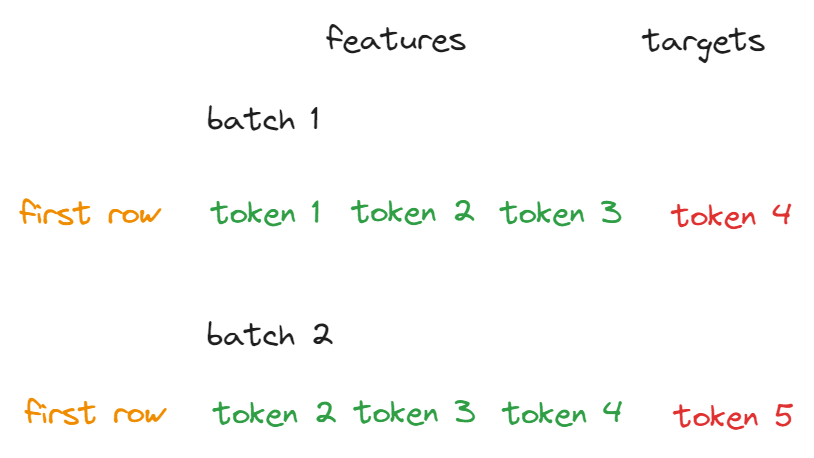
</div>

In [15]:
def group_chunks(seqs_tokens: List, 
                 batch_size: int=64) -> List:
    # Get the number of full batches
    num_batches = len(seqs_tokens) // batch_size
    for b in range(num_batches):
        batch = []
        for row in range(batch_size):
            batch.append(seqs_tokens[b + num_batches*row])
        yield batch
        
# Test
for i, batch in enumerate(group_chunks(seqs_tokens[:10],
                                       batch_size=3)):
    print(f"Batch {i}:")
    print(batch)

Batch 0:
[(tensor([0, 1, 2]), tensor(1)), (tensor([1, 6, 1]), tensor(7)), (tensor([10,  1, 11]), tensor(1))]
Batch 1:
[(tensor([1, 3, 1]), tensor(4)), (tensor([7, 1, 8]), tensor(1)), (tensor([ 1, 12,  1]), tensor(13))]
Batch 2:
[(tensor([4, 1, 5]), tensor(1)), (tensor([1, 9, 1]), tensor(10)), (tensor([13,  1, 14]), tensor(1))]


In [16]:
batch_size = 64

# Create chunks and flatten the batches
grouped_train_seqs = [seq for chunk in group_chunks(train_seqs, batch_size) for seq in chunk]
grouped_val_seqs = [seq for chunk in group_chunks(val_seqs, batch_size) for seq in chunk]

# Recreate the datasets and dataloaders
grouped_train_set = NumbersDataset(grouped_train_seqs)
grouped_val_set = NumbersDataset(grouped_val_seqs)

# Don't shuffle
grouped_train_loader = DataLoader(grouped_train_set,
                                  batch_size=batch_size,
                                  shuffle=False)
grouped_val_loader = DataLoader(grouped_val_set,
                                batch_size=batch_size,
                                shuffle=False)

### State-aware RNN

In [17]:
class SimpleRNNWithState(torch.nn.Module):
    def __init__(self,
                 vocab_size: int,
                 n_hidden: int=3):
        super(SimpleRNNWithState, self).__init__()
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        
        # Layers
        self.input_layer = torch.nn.Embedding(vocab_size, n_hidden) # Lookup table
        self.hidden_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.output_layer = torch.nn.Linear(n_hidden, vocab_size)
        
        # Hidden state
        self.hidden_state = 0
        
    def forward(self, 
                X: torch.tensor,
                y: Union[None, torch.tensor]=None) -> Dict:
        # Implement a for-loop
        for i in range(3):
            self.hidden_state = self.hidden_state + self.input_layer(X[:, i])
            self.hidden_state = self.hidden_layer(self.hidden_state)
            self.hidden_state = torch.nn.functional.relu(self.hidden_state)
        last_hidden_state = self.output_layer(self.hidden_state)
        
        # Prevent backpropagating the derivatives through all hidden states
        self.hidden_state = self.hidden_state.detach()
        out = {"last_hidden_state": last_hidden_state}
        
        # Calculate the loss
        if y is not None:
            loss = torch.nn.functional.cross_entropy(last_hidden_state, y.view(-1,))
            out.update({"loss": loss})
        return out
    
    def reset(self):
        """
        Resets the previous hidden states to zero
        """
        self.hidden_state = 0

### New train function with callback

In [18]:
def train_state_network(model,
                        train_loader: DataLoader,
                        val_loader: Union[None, DataLoader]=None,
                        optimizer: torch.optim.Optimizer=torch.optim.AdamW, 
                        n_epochs: int=1,
                        learning_rate: float=1e-3,
                        device: Union[None, str]=None):
    """
    Train the network and report metrics.
    """
    # Checks device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Optimizer
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(1, n_epochs + 1), desc="Epochs"):
        # Start timer
        start_time = perf_counter()
        
        # Train model and reset the hidden state
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        model.reset()
        
        # Evaluate on validation set and reset the hidden state
        val_loss, val_acc = evaluate_one_epoch(model, val_loader, device)
        model.reset()
        
        # Stop timer and calculate the epoch time in seconds
        end_time = perf_counter()
        epoch_time = end_time - start_time # Seconds
        
        # Report
        print(f"Epoch {epoch} - Train Loss: {train_loss:.3f} - Eval Loss: {val_loss:.3f} - Eval Accuracy: {val_acc:.3f} - Time {epoch_time:.1f}")

In [19]:
# Train the model
torch.manual_seed(123)
vocab_size = len(vocab)
model = SimpleRNNWithState(vocab_size, 64)
train_state_network(model,
                    grouped_train_loader,
                    grouped_val_loader,
                    n_epochs=10,
                    learning_rate=3e-3)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.493 - Eval Loss: 1.720 - Eval Accuracy: 0.474 - Time 0.9


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.139 - Eval Loss: 1.742 - Eval Accuracy: 0.510 - Time 0.8


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.040 - Eval Loss: 1.757 - Eval Accuracy: 0.518 - Time 0.9


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.017 - Eval Loss: 1.772 - Eval Accuracy: 0.549 - Time 0.9


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.000 - Eval Loss: 1.833 - Eval Accuracy: 0.529 - Time 1.0


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.969 - Eval Loss: 1.999 - Eval Accuracy: 0.494 - Time 1.0


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.982 - Eval Loss: 2.044 - Eval Accuracy: 0.533 - Time 1.9


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.963 - Eval Loss: 1.930 - Eval Accuracy: 0.511 - Time 2.1


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.930 - Eval Loss: 1.929 - Eval Accuracy: 0.527 - Time 1.8


Train batches:   0%|          | 0/262 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.939 - Eval Loss: 1.971 - Eval Accuracy: 0.570 - Time 1.2


## Creating more signal

Instead of using three tokens to predict the next one we could make the network predict the next token after every single token. This way we add even more *recurrency* to the network and it updates it's weights with more data.

### Refactoring the data

In [20]:
def apply_window(sequence: List,
                 seq_length: int=3,
                 offset: int=1) -> List:
    """
    Apply windowing to a sequence of tokens.
    """
    windowed_seq = []
    for i in range(0, len(sequence) - seq_length, offset):
        features = sequence[i: i + seq_length]
        targets = sequence[i + offset: i + seq_length + offset]
        windowed_seq.append(tuple([torch.tensor(features),
                                   torch.tensor(targets)]))
    return windowed_seq

In [21]:
# Tokenize all data
tokens = [tok2idx[tok] for tok in tokens]
tokens[:10]

[0, 1, 2, 1, 3, 1, 4, 1, 5, 1]

In [22]:
def create_dataset(sequences: List,
                   seq_length: int=3, 
                   offset: int=1,
                   batch_size: int=64):
    """
    Wrapper to apply all preprocessing and 
    return a NumbersDataset.
    """
    windowed_seqs = apply_window(sequences, seq_length, offset)
    chunks = group_chunks(windowed_seqs, batch_size)
    # Flatten the sequences inside the chunks
    grouped_seqs = [seq for chunk in chunks for seq in chunk]
    return NumbersDataset(grouped_seqs)

In [23]:
# Split into train/val
train_tokens, val_tokens = train_test_split(tokens,
                                            test_size=.2,
                                            shuffle=False)
train_tokens[:10]

[0, 1, 2, 1, 3, 1, 4, 1, 5, 1]

In [24]:
# Create the new datasets
train_set = create_dataset(train_tokens)
val_set = create_dataset(val_tokens)
train_set[:10]

(tensor([[ 0,  1,  2],
         [ 2, 28, 12],
         [28, 25,  8],
         [ 1,  5, 28],
         [28, 14,  1],
         [ 8, 28, 26],
         [ 8,  1,  0],
         [28, 26,  1],
         [28, 27,  7],
         [16,  1,  0]]),
 tensor([[ 1,  2,  1],
         [28, 12,  1],
         [25,  8,  1],
         [ 5, 28, 22],
         [14,  1,  7],
         [28, 26,  1],
         [ 1,  0, 29],
         [26,  1,  0],
         [27,  7,  1],
         [ 1,  0, 29]]))

In [25]:
# Create dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

### RNN with longer context

- Implement a for-loop to handle longer sequences with more context as well as predicting further into the future.

In [26]:
class SimpleRNNWithState(torch.nn.Module):
    def __init__(self,
                 vocab_size: int,
                 n_hidden: int=3):
        super(SimpleRNNWithState, self).__init__()
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        
        # Layers
        self.input_layer = torch.nn.Embedding(vocab_size, n_hidden) # Lookup table
        self.hidden_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.output_layer = torch.nn.Linear(n_hidden, vocab_size)
        
        # Hidden state
        self.hidden_state = 0
        
    def forward(self, 
                X: torch.tensor,
                y: Union[None, torch.tensor]=None) -> Dict:
        assert X.ndim == 2, "X must be a 2D tensor of shape (batch_size, seq_length)."
        if y is not None:
            assert all(xdim==ydim for xdim, ydim in zip(X.shape, y.shape)), "X and y shapes must match."
        
        # Implement a for-loop
        last_hidden_state = []
        for i in range(X.shape[1]):
            self.hidden_state = self.hidden_state + self.input_layer(X[:, i])
            self.hidden_state = self.hidden_layer(self.hidden_state)
            self.hidden_state = torch.nn.functional.relu(self.hidden_state)
            out = self.output_layer(self.hidden_state) # (batch_size, vocab_size)
            last_hidden_state.append(out) # (seq_length, batch_size, vocab_size)
        
        # Stack outputs to group the sequences into each row of the batch
        # (seq_length, batch_size, vocab_size) -> (batch_size, seq_length, vocab_size)
        last_hidden_state = torch.stack(last_hidden_state, dim=1)
        
        # Prevent backpropagating the derivatives through all hidden states
        self.hidden_state = self.hidden_state.detach()
        model_output = {"last_hidden_state": last_hidden_state}
        
        # Calculate the loss
        if y is not None:
            # Reshape last hidden states and targets to flatten the sequences
            # (batch_size, seq_length, vocab_size) -> (batch_size * seq_length, vocab_size)
            last_hidden_state = last_hidden_state.view(-1, self.vocab_size)
            # (batch_size, seq_length) -> (batch_size * seq_length)
            y = y.view(-1,)
            loss = torch.nn.functional.cross_entropy(last_hidden_state, y)
            model_output.update({"loss": loss})
        return model_output
    
    def reset(self):
        """
        Resets the previous hidden states to zero
        """
        self.hidden_state = 0

In [27]:
# Train the model
torch.manual_seed(123)
model = SimpleRNNWithState(vocab_size, 64)
train_state_network(model,
                    train_loader,
                    val_loader,
                    n_epochs=15,
                    learning_rate=3e-3)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.388 - Eval Loss: 1.675 - Eval Accuracy: 0.535 - Time 3.4


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.335 - Eval Loss: 1.760 - Eval Accuracy: 0.438 - Time 3.7


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.261 - Eval Loss: 1.840 - Eval Accuracy: 0.476 - Time 3.9


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.244 - Eval Loss: 1.806 - Eval Accuracy: 0.470 - Time 2.9


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.222 - Eval Loss: 1.849 - Eval Accuracy: 0.429 - Time 2.8


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 1.246 - Eval Loss: 1.769 - Eval Accuracy: 0.513 - Time 3.1


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 1.261 - Eval Loss: 1.818 - Eval Accuracy: 0.509 - Time 3.2


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 1.219 - Eval Loss: 1.792 - Eval Accuracy: 0.497 - Time 2.9


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 1.191 - Eval Loss: 1.869 - Eval Accuracy: 0.441 - Time 2.8


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 1.191 - Eval Loss: 1.813 - Eval Accuracy: 0.544 - Time 3.0


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 1.188 - Eval Loss: 2.034 - Eval Accuracy: 0.459 - Time 2.9


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 1.172 - Eval Loss: 2.114 - Eval Accuracy: 0.464 - Time 2.4


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 1.222 - Eval Loss: 1.849 - Eval Accuracy: 0.487 - Time 2.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 1.208 - Eval Loss: 1.944 - Eval Accuracy: 0.449 - Time 2.1


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 1.237 - Eval Loss: 1.881 - Eval Accuracy: 0.451 - Time 2.4


In [28]:
# Let's add even more context - Trying 16 tokens

# Create the new datasets
train_set = create_dataset(train_tokens, seq_length=16)
val_set = create_dataset(val_tokens, seq_length=16)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Train the model
torch.manual_seed(123)
model = SimpleRNNWithState(vocab_size, 64)
train_state_network(model,
                    train_loader,
                    val_loader,
                    n_epochs=15,
                    learning_rate=3e-3)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.143 - Eval Loss: 2.343 - Eval Accuracy: 0.474 - Time 6.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.803 - Eval Loss: 2.556 - Eval Accuracy: 0.526 - Time 7.0


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.624 - Eval Loss: 2.912 - Eval Accuracy: 0.478 - Time 6.4


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.508 - Eval Loss: 2.918 - Eval Accuracy: 0.530 - Time 6.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.441 - Eval Loss: 2.973 - Eval Accuracy: 0.593 - Time 9.1


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.377 - Eval Loss: 2.917 - Eval Accuracy: 0.636 - Time 8.4


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.341 - Eval Loss: 3.215 - Eval Accuracy: 0.598 - Time 8.5


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.304 - Eval Loss: 3.566 - Eval Accuracy: 0.604 - Time 7.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.276 - Eval Loss: 3.859 - Eval Accuracy: 0.602 - Time 7.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.262 - Eval Loss: 3.511 - Eval Accuracy: 0.653 - Time 8.0


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.245 - Eval Loss: 3.834 - Eval Accuracy: 0.572 - Time 11.5


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.235 - Eval Loss: 3.724 - Eval Accuracy: 0.623 - Time 7.9


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.233 - Eval Loss: 3.438 - Eval Accuracy: 0.635 - Time 6.9


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.214 - Eval Loss: 3.922 - Eval Accuracy: 0.550 - Time 8.8


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.216 - Eval Loss: 3.258 - Eval Accuracy: 0.611 - Time 7.0


## Multilayer RNN

In [29]:
class MultilayerRNN(torch.nn.Module):
    def __init__(self,
                 vocab_size: int,
                 n_layers: int=1,
                 n_hidden: int=3):
        super(MultilayerRNN, self).__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        # Layers
        self.input_layer = torch.nn.Embedding(self.vocab_size,
                                              self.n_hidden)
        self.rnn = torch.nn.RNN(self.n_hidden,
                                self.n_hidden,
                                self.n_layers,
                                batch_first=True)
        self.output_layer = torch.nn.Linear(self.n_hidden,
                                            self.vocab_size)
        
        # To initialize the hidden state
        self.first_pass = True
        
        
    def forward(self, X, y):
        assert X.ndim == 2, "X must be a 2D tensor of shape (batch_size, seq_length)."
        if y is not None:
            assert all(xdim==ydim for xdim, ydim in zip(X.shape, y.shape)), "X and y shapes must match."
        
        batch_size = X.shape[0]
        if self.first_pass:
            self.hidden_state = torch.zeros(self.n_layers, 
                                            batch_size,
                                            self.n_hidden)
        # Forward through the network
        res, hidden_state = self.rnn(self.input_layer(X), self.hidden_state)
        self.hidden_state = hidden_state.detach()
        last_hidden_state = self.output_layer(res)
        model_output = {"last_hidden_state": last_hidden_state}

        # Calculate the loss
        if y is not None:
            # Reshape last hidden states and targets to flatten the sequences
            # (batch_size, seq_length, vocab_size) -> (batch_size * seq_length, vocab_size)
            # (batch_size, seq_length) -> (batch_size * seq_length)
            loss = torch.nn.functional.cross_entropy(last_hidden_state.view(-1, self.vocab_size),
                                                     y.view(-1,))
            model_output.update({"loss": loss})

        return model_output


    def reset(self):
        self.hidden_state.zero_()
            
            
# Train the model
torch.manual_seed(123)
model = MultilayerRNN(vocab_size,
                      n_layers=2,
                      n_hidden=64)

train_state_network(model,
                    train_loader,
                    val_loader,
                    n_epochs=15,
                    learning_rate=3e-3)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.110 - Eval Loss: 2.408 - Eval Accuracy: 0.389 - Time 8.0


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.887 - Eval Loss: 2.605 - Eval Accuracy: 0.368 - Time 9.1


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.840 - Eval Loss: 2.610 - Eval Accuracy: 0.434 - Time 11.7


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.822 - Eval Loss: 2.620 - Eval Accuracy: 0.467 - Time 10.6


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.829 - Eval Loss: 2.852 - Eval Accuracy: 0.416 - Time 8.7


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.830 - Eval Loss: 2.737 - Eval Accuracy: 0.457 - Time 8.6


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.833 - Eval Loss: 2.764 - Eval Accuracy: 0.395 - Time 8.8


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.840 - Eval Loss: 2.609 - Eval Accuracy: 0.415 - Time 8.6


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.854 - Eval Loss: 2.555 - Eval Accuracy: 0.396 - Time 8.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.855 - Eval Loss: 3.057 - Eval Accuracy: 0.314 - Time 8.4


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.867 - Eval Loss: 2.733 - Eval Accuracy: 0.377 - Time 8.6


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.854 - Eval Loss: 2.624 - Eval Accuracy: 0.412 - Time 8.6


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.854 - Eval Loss: 2.569 - Eval Accuracy: 0.424 - Time 8.4


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.871 - Eval Loss: 3.097 - Eval Accuracy: 0.365 - Time 8.3


Train batches:   0%|          | 0/788 [00:00<?, ?it/s]

Eval batches:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.871 - Eval Loss: 2.510 - Eval Accuracy: 0.375 - Time 8.4
